In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import cmocean.cm as cm
import os
from datetime import datetime, timedelta
import glob


In [2]:
# Define simulation paths
BASE_PATHS = {
    "Baseline": "/ocean/atall/MOAD/Model/202410b/oxygen",
    "WWTP_freshw": "/ocean/atall/MOAD/Model/202410b/wastewatero2_freshwater", 
    "WWTP_withNut": "/ocean/atall/MOAD/Model/202410b/wastewatero2"
}

# Load mesh mask and WWTP positions
with xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc') as mesh:
    depth = mesh.gdept_0.values  # Depth of T-points (time, depth, y, x)
    e3t = mesh.e3t_0.values      # Vertical cell thickness (time, depth, y, x)
    mbathy = mesh.mbathy.values  # Number of vertical levels


In [9]:
# Load WWTP positions and categorize by DISCHARGE DEPTH
wwtp_positions = "/ocean/atall/MOAD/Obs/PugetSound/WWTP/wastewater_20251118.nc"
src = xr.open_dataset(wwtp_positions)
flux_nonzero = src["flux"].max(dim="time_counter") > 0
source_indices = np.argwhere(flux_nonzero.values)
all_y, all_x = zip(*source_indices)
all_y = np.array(all_y)
all_x = np.array(all_x)

mbathy_data = mbathy
depth_data = depth
mbathy_vals = mbathy_data[0, all_y, all_x] - 1
valid_indices = mbathy_vals.astype(int)
wwtp_discharge_depths = depth_data[0, valid_indices, all_y, all_x]

#depth_ranges = [0.5, 10, 20, 50, 200]
#depth_labels = ['0-10m', '10-20m', '20-50m', '50-200m']
#colors = ['blue', 'green', 'orange', 'red']
depth_ranges = [0.5, 50, 200]
depth_labels = ['0-50m', '>50m']
colors = ['green', 'red']

depth_categories = np.digitize(wwtp_discharge_depths, depth_ranges) - 1
depth_categories = np.clip(depth_categories, 0, len(depth_ranges)-2)

for i, label in enumerate(depth_labels):
    count = np.sum(depth_categories == i)
    if count > 0:
        avg_depth = np.mean(wwtp_discharge_depths[depth_categories == i])
        print(f"{label}: {count} WWTPs (avg discharge depth: {avg_depth:.1f}m)")
print(f"Total WWTPs: {len(all_y)}")

# Create groups for each discharge depth category
category_groups = {}
for i, label in enumerate(depth_labels):
    mask = depth_categories == i
    if np.any(mask):
        category_groups[label] = {
            'indices': np.where(mask)[0],
            'y': all_y[mask],
            'x': all_x[mask],
            'discharge_depths': wwtp_discharge_depths[mask],
            'color': colors[i],
            'n_wwtps': np.sum(mask)
        }
    else:
        category_groups[label] = None


0-50m: 77 WWTPs (avg discharge depth: 15.6m)
>50m: 21 WWTPs (avg discharge depth: 91.1m)
Total WWTPs: 98


In [16]:
# FUNCTIONS
def get_daily_files(base_path, start_date, end_date):
    """Get list of daily files for a given period"""
    files = []
    current_date = start_date
    
    while current_date <= end_date:
        day_str = f"{current_date.day:02d}"
        month_str = current_date.strftime("%b").lower()
        year_str = str(current_date.year)[-2:]
        dir_name = f"{day_str}{month_str}{year_str}"
        dir_path = os.path.join(base_path, dir_name)
        
        if os.path.exists(dir_path):
            date_str = current_date.strftime("%Y%m%d")
            chem_file = f"SalishSea_1d_{date_str}_{date_str}_chem_T.nc"
            biol_file = f"SalishSea_1d_{date_str}_{date_str}_biol_T.nc"
            
            chem_path = os.path.join(dir_path, chem_file)
            biol_path = os.path.join(dir_path, biol_file)
            
            if os.path.exists(chem_path) and os.path.exists(biol_path):
                files.append((current_date, chem_path, biol_path))
        
        current_date += timedelta(days=1)
    
    return files

def integrate_at_wwtp_locations(ds_chem, ds_biol, category_groups, mbathy_data, depth_data, e3t):
    """
    Integrate variables at WWTP locations, grouped by discharge depth
    
    Returns integrated values for each depth category
    """
    results = {}
    
    for label, group in category_groups.items():
        if group is None or group['n_wwtps'] == 0:
            results[label] = None
            continue
        
        # Initialize sums for this depth category
        nitrate_sum = 0
        ammonium_sum = 0
        diatoms_sum = 0
        flagellates_sum = 0
        pon_sum = 0
        don_sum = 0
        oxygen_upper_sum = 0  # 0-50m
        oxygen_lower_sum = 0  # >50m
        
        # Process each WWTP in this depth category
        for i in range(group['n_wwtps']):
            y = group['y'][i]
            x = group['x'][i]
            
            # Number of vertical levels at this location
            n_levels = int(mbathy_data[0, y, x])
            if n_levels == 0:
                continue
            
            # Get depth and thickness arrays for this point
            depth_slice = depth_data[0, :n_levels, y, x]
            e3t_slice = e3t[0, :n_levels, y, x]
            
            # NITRATE - integrate whole water column
            if 'nitrate' in ds_biol.variables:
                nitrate_profile = ds_biol.nitrate.values[0, :n_levels, y, x]
                nitrate_integrated = np.sum(nitrate_profile * e3t_slice)
                nitrate_sum += nitrate_integrated
            
            # AMMONIUM - integrate whole water column
            if 'ammonium' in ds_biol.variables:
                ammonium_profile = ds_biol.ammonium.values[0, :n_levels, y, x]
                ammonium_integrated = np.sum(ammonium_profile * e3t_slice)
                ammonium_sum += ammonium_integrated
            
            # DIATOMS - integrate whole water column
            if 'diatoms' in ds_biol.variables:
                diatoms_profile = ds_biol.diatoms.values[0, :n_levels, y, x]
                diatoms_integrated = np.sum(diatoms_profile * e3t_slice)
                diatoms_sum += diatoms_integrated

            # FLAGELLATES - integrate whole water column
            if 'flagellates' in ds_biol.variables:
                flagellates_profile = ds_biol.flagellates.values[0, :n_levels, y, x]
                flagellates_integrated = np.sum(flagellates_profile * e3t_slice)
                flagellates_sum += flagellates_integrated
            
            # PON - integrate whole water column
            if 'particulate_organic_nitrogen' in ds_biol.variables:
                pon_profile = ds_biol.particulate_organic_nitrogen.values[0, :n_levels, y, x]
                pon_integrated = np.sum(pon_profile * e3t_slice)
                pon_sum += pon_integrated
            
            # DON - integrate whole water column
            if 'dissolved_organic_nitrogen' in ds_biol.variables:
                don_profile = ds_biol.dissolved_organic_nitrogen.values[0, :n_levels, y, x]
                don_integrated = np.sum(don_profile * e3t_slice)
                don_sum += don_integrated

            # DISSOLVED OXYGEN - separate integration for 0-50m and >50m
            if 'dissolved_oxygen' in ds_chem.variables:
                oxygen_profile = ds_chem.dissolved_oxygen.values[0, :n_levels, y, x]
                
                # Create masks for depth layers
                mask_upper = depth_slice <= 50
                mask_lower = depth_slice > 50
                
                oxygen_upper = np.sum(oxygen_profile[mask_upper] * e3t_slice[mask_upper])
                oxygen_lower = np.sum(oxygen_profile[mask_lower] * e3t_slice[mask_lower])
                
                oxygen_upper_sum += oxygen_upper
                oxygen_lower_sum += oxygen_lower
            
        
        # Store results for this depth category
        results[label] = {
            'nitrate': nitrate_sum,
            'ammonium': ammonium_sum,
            'diatoms': diatoms_sum,
            'flagellates': flagellates_sum,
            'PON': pon_sum,
            'DON': don_sum,
            'oxygen_upper': oxygen_upper_sum,
            'oxygen_lower': oxygen_lower_sum,
            'n_wwtps': group['n_wwtps'],
            'avg_discharge_depth': np.mean(group['discharge_depths']) if len(group['discharge_depths']) > 0 else 0
        }
    
    return results

def process_simulation_by_discharge_depth(sim_name, base_path, start_date, end_date, category_groups):
    """Process simulation results for WWTPs grouped by discharge depth"""
    
    print(f"\nProcessing {sim_name}...")
    daily_files = get_daily_files(base_path, start_date, end_date)
    
    if not daily_files:
        print(f"No files found for {sim_name}")
        return None
    
    # Initialize results structure
    results = {
        'time': [],
        'categories': {}
    }
    
    for label in depth_labels:
        if category_groups[label] is not None:
            results['categories'][label] = {
                'nitrate': [],
                'ammonium': [],
                'diatoms': [],
                'flagellates': [],
                'PON': [],
                'DON': [],
                'oxygen_upper': [],
                'oxygen_lower': []
            }
    
    # Process each day
    for date, chem_path, biol_path in daily_files:
        try:
            # Open daily files
            ds_chem = xr.open_dataset(chem_path)
            ds_biol = xr.open_dataset(biol_path)
            
            # Extract time
            time_val = ds_chem.time_counter.values[0]
            results['time'].append(time_val)
            
            # Integrate at WWTP locations for each depth category
            daily_results = integrate_at_wwtp_locations(
                ds_chem, ds_biol, category_groups, 
                mbathy_data, depth_data, e3t
            )
            
            # Store daily results
            for label in depth_labels:
                if label in daily_results and daily_results[label] is not None:
                    cat_results = daily_results[label]
                    results['categories'][label]['nitrate'].append(cat_results['nitrate'])
                    results['categories'][label]['ammonium'].append(cat_results['ammonium'])
                    results['categories'][label]['diatoms'].append(cat_results['diatoms'])
                    results['categories'][label]['flagellates'].append(cat_results['flagellates'])
                    results['categories'][label]['PON'].append(cat_results['PON'])
                    results['categories'][label]['DON'].append(cat_results['DON'])
                    results['categories'][label]['oxygen_upper'].append(cat_results['oxygen_upper'])
                    results['categories'][label]['oxygen_lower'].append(cat_results['oxygen_lower'])
            
            ds_chem.close()
            ds_biol.close()
            
        except Exception as e:
            print(f"Error processing {date}: {e}")
            continue
    
    # Convert lists to arrays
    results['time'] = np.array(results['time'])
    
    for label in depth_labels:
        if label in results['categories']:
            for var in results['categories'][label]:
                results['categories'][label][var] = np.array(results['categories'][label][var])
    
    return results

def plot_by_discharge_depth(results_dict, start_date, end_date):
    """Plot integrated variables by WWTP discharge depth category"""
    
    # Variables to plot
    variables = [
        ('nitrate', 'NO3', 'mmol', 'water column'),
        ('ammonium', 'NH4', 'mmol', 'water column'),
        ('diatoms', 'DIAT', 'mmol', 'water column'),
        ('flagellates', 'FLAG', 'mmol', 'water column'),
        ('PON', 'PON', 'mmol', 'water column'),
        ('DON', 'DON', 'mmol', 'water column'),
        ('oxygen_upper', 'DO (0-50m)', 'mmol', '0-50m layer'),
        ('oxygen_lower', 'DO (>50m)', 'mmol', '>50m layer')
    ]
    
    # Create one figure per variable
    for var_name, var_title, var_units, var_note in variables:
        categories_with_data = []
        for label in depth_labels:
            if (any(var_name in results_dict[sim]['categories'][label] 
                   for sim in results_dict if results_dict[sim] is not None) and
                category_groups[label] is not None):
                categories_with_data.append(label)
        
        if not categories_with_data:
            continue
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for sim_name, results in results_dict.items():
            if results is None:
                continue
            
            for label in categories_with_data:
                if label not in results['categories']:
                    continue
                
                var_data = results['categories'][label][var_name]
                if len(var_data) == 0:
                    continue
                
                time_dates = [datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(float)) 
                             for t in results['time']]
                
                linestyle = '-'
                if sim_name == 'WWTP_freshw':
                    linestyle = '--'
                elif sim_name == 'WWTP_withNut':
                    linestyle = ':'
                
                ax.plot(time_dates, var_data,
                       color=category_groups[label]['color'],
                       linestyle=linestyle,
                       label=f'{sim_name} - {label} ({category_groups[label]["n_wwtps"]} WWTPs)',
                       linewidth=2)
        
        ax.set_title(f'{var_title} at WWTPs discharge depth\n{var_note}', 
                    fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Integrated {var_title} ({var_units})')
        ax.set_xlabel('Date')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

def plot_relative_impacts(results_dict):
    """Plot relative impacts of WWTPs by discharge depth"""
    
    if 'Baseline' not in results_dict or 'WWTP_withNut' not in results_dict:
        return
    
    baseline = results_dict['Baseline']
    wwtp_nut = results_dict['WWTP_withNut']
    
    # Calculate percentage differences
    variables = ['nitrate', 'ammonium', 'diatoms', 'flagellates', 'oxygen_upper', 'oxygen_lower']
    var_titles = ['Nitrate', 'Ammonium', 'Diatoms', 'Flagellates', 'DO (0-50m)', 'DO (>50m)']
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    axes = axes.flatten()
    
    for idx, (var_name, var_title) in enumerate(zip(variables, var_titles)):
        ax = axes[idx]
        
        for label in depth_labels:
            if (category_groups[label] is None or 
                label not in baseline['categories'] or 
                label not in wwtp_nut['categories']):
                continue
            
            baseline_data = baseline['categories'][label][var_name]
            wwtp_data = wwtp_nut['categories'][label][var_name]
            
            if len(baseline_data) == 0 or len(wwtp_data) == 0:
                continue
            
            # Ensure same length
            min_len = min(len(baseline_data), len(wwtp_data))
            baseline_data = baseline_data[:min_len]
            wwtp_data = wwtp_data[:min_len]
            
            # Calculate percentage difference (avoid division by zero)
            with np.errstate(divide='ignore', invalid='ignore'):
                percent_diff = 100 * (wwtp_data - baseline_data) / np.where(baseline_data != 0, baseline_data, 1)
            
            # Convert time to datetime
            time_dates = [datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(float)) 
                         for t in baseline['time'][:min_len]]
            
            # Plot
            ax.plot(time_dates, percent_diff,
                   color=category_groups[label]['color'],
                   label=f'{label} ({category_groups[label]["n_wwtps"]} WWTPs)',
                   linewidth=2)
        
        ax.set_title(f'{var_title} - Percent Difference from Baseline', fontsize=11, fontweight='bold')
        ax.set_ylabel('Percent Difference (%)')
        ax.set_xlabel('Date')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.5, linewidth=0.5)
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Relative Impact of WWTPs with Nutrients by Discharge Depth', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_wwtp_discharge_depth_distribution():
    """Plot the distribution of WWTPs by discharge depth
    and their locations on bathymetry"""
    
    bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')
    bathy_data = bathy.variables['Bathymetry'][:]
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))
    
    # Depth distribution
    ax1 = axes[0]
    
    for label, cat_info in category_groups.items():
        if len(cat_info['indices']) > 0:
            ax1.scatter(cat_info['x'], cat_info['discharge_depths'], 
                         color=cat_info['color'], label=label, s=50)
    
    ax1.set_xlabel('X-Position')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('WWTP Depth Distribution')
    ax1.invert_yaxis()
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add statistics
    #stats_text = "\n".join([f"{label}: {len(cat_info['indices'])} WWTPs" 
    #                       for label, cat_info in category_indices.items()])
    #ax1.text(0.02, 0.5, stats_text, transform=ax1.transAxes,
    #           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Pie chart by depth range
    ax2 = axes[1]
    sizes = []
    labels_pie = []
    colors_pie = []
    
    for label in depth_labels:
        if category_groups[label] is not None:
            sizes.append(category_groups[label]['n_wwtps'])
            labels_pie.append(f'{label}\n({category_groups[label]["n_wwtps"]} WWTPs)')
            colors_pie.append(category_groups[label]['color'])
    
    if sizes:
        ax2.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
        ax2.set_title('WWTPs by Discharge Depth')
    
    # Locations on bathymetry
    ax3 = axes[2]
    bathy_plot = ax3.pcolormesh(bathy_data, cmap=cm.thermal, vmin=4, vmax=450)
    cbar = plt.colorbar(bathy_plot, ax=ax3)
    cbar.set_label('Bathymetry (m)')
    
    for label, cat_info in category_groups.items():
        if len(cat_info['indices']) > 0:
            ax3.scatter(cat_info['x'], cat_info['y'], 
                         color=cat_info['color'], label=label, s=50,
                         edgecolors='white', linewidth=0.5)
    
    ax3.set_xlabel('X-Position')
    ax3.set_ylabel('Y-Position')
    ax3.set_title('WWTP Locations by Depth Range')
    ax3.legend(title='Depth Ranges')
    ax3.set_ylim(0, 500)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


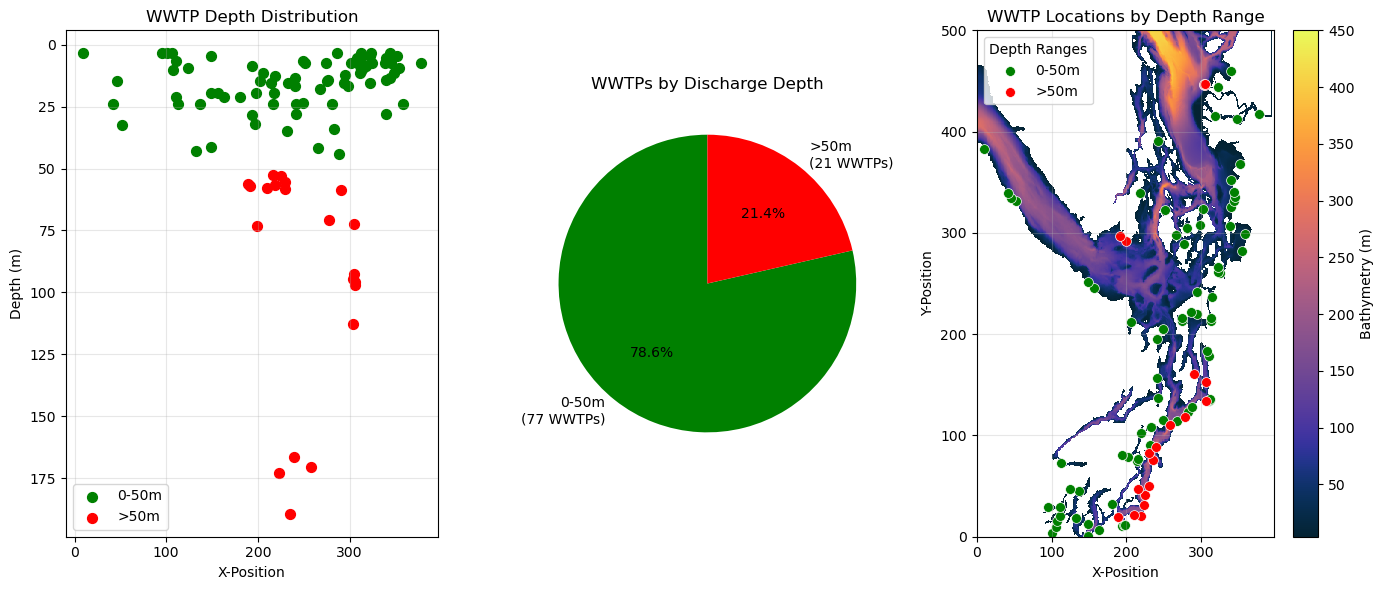


Processing Baseline...

Processing WWTP_freshw...

Processing WWTP_withNut...


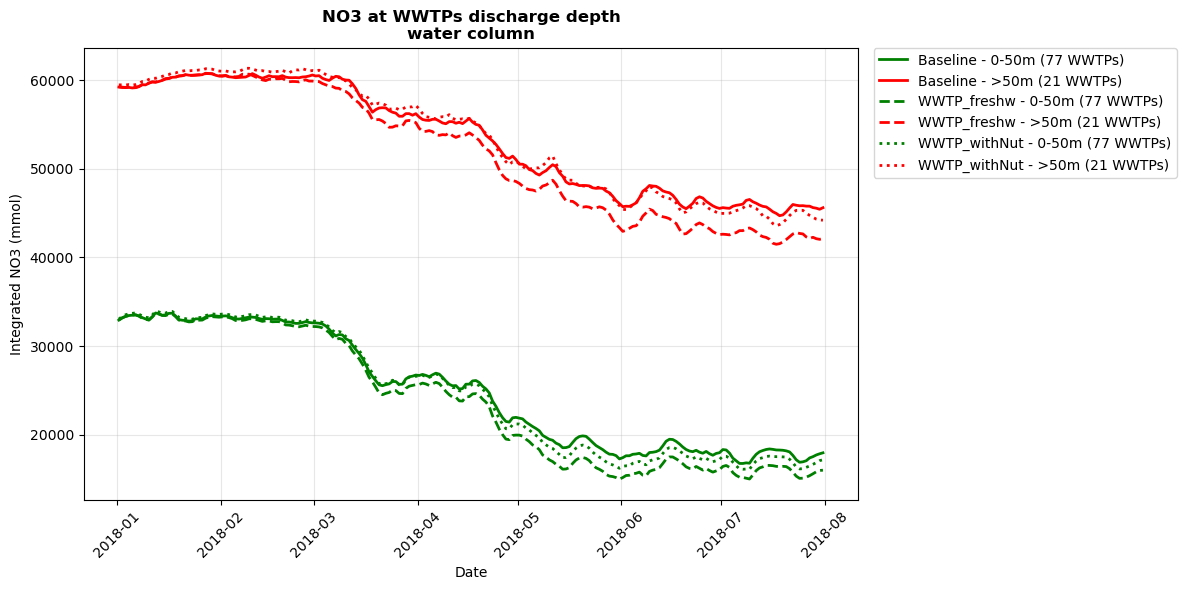

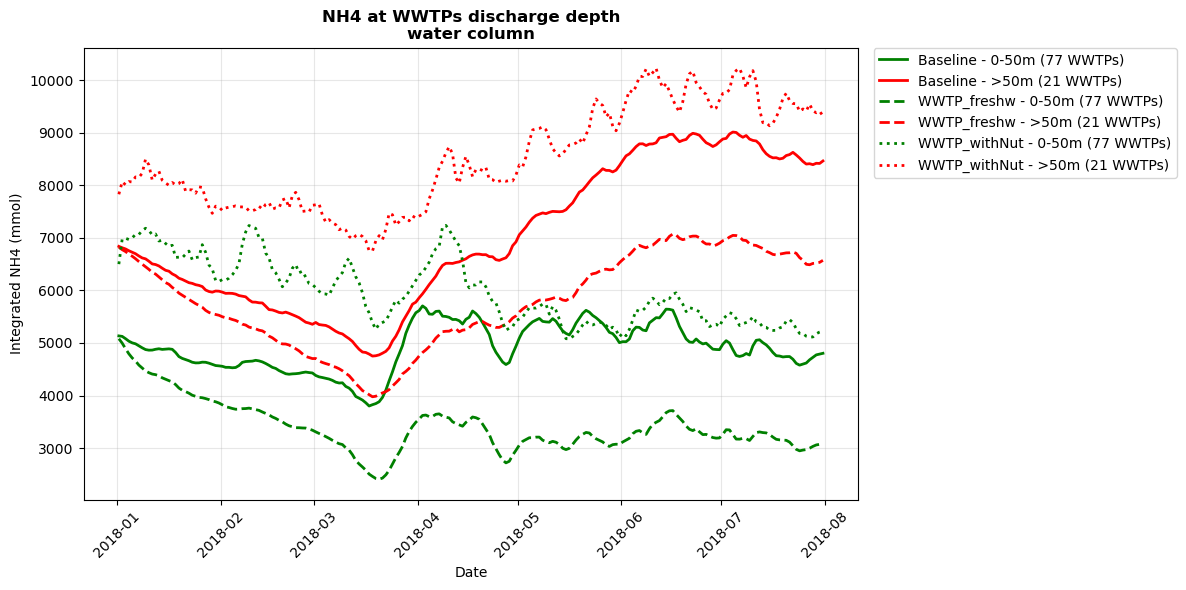

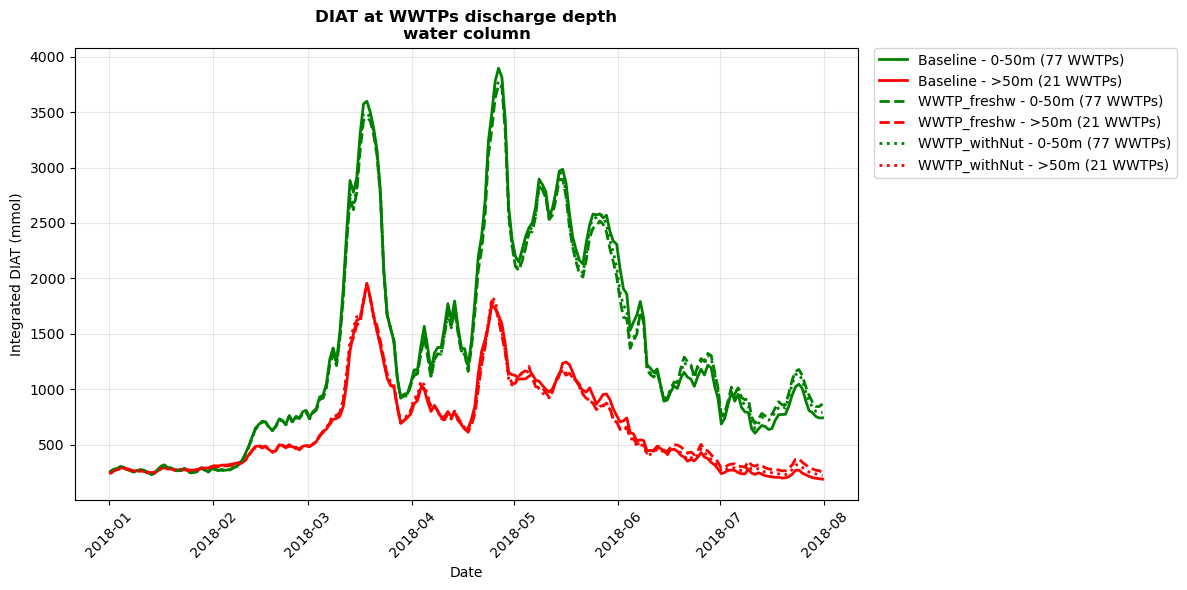

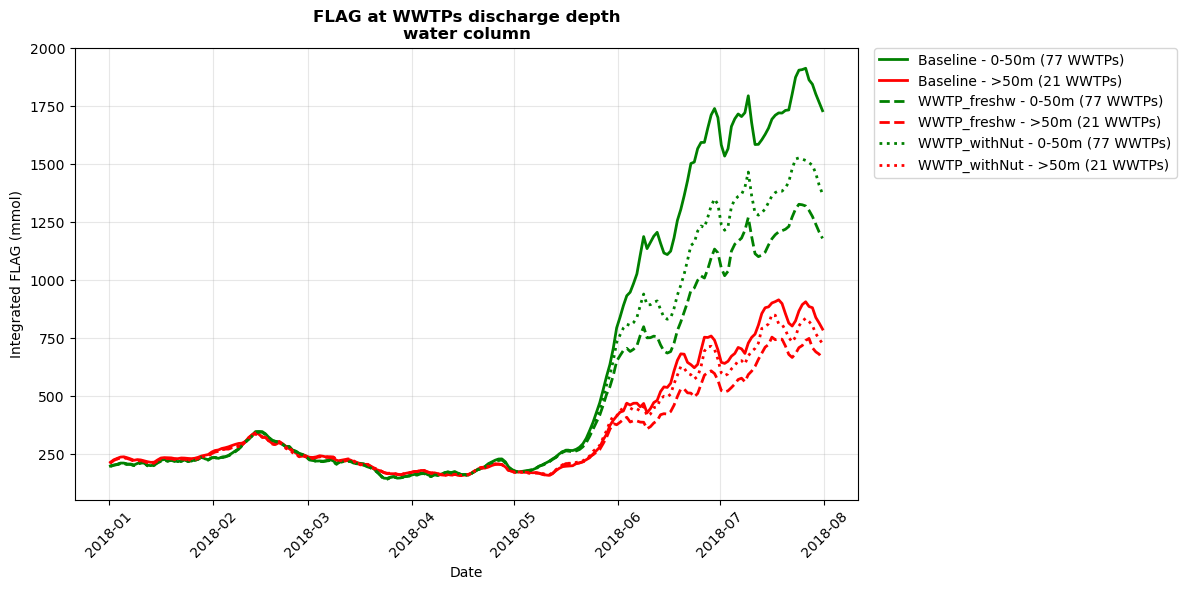

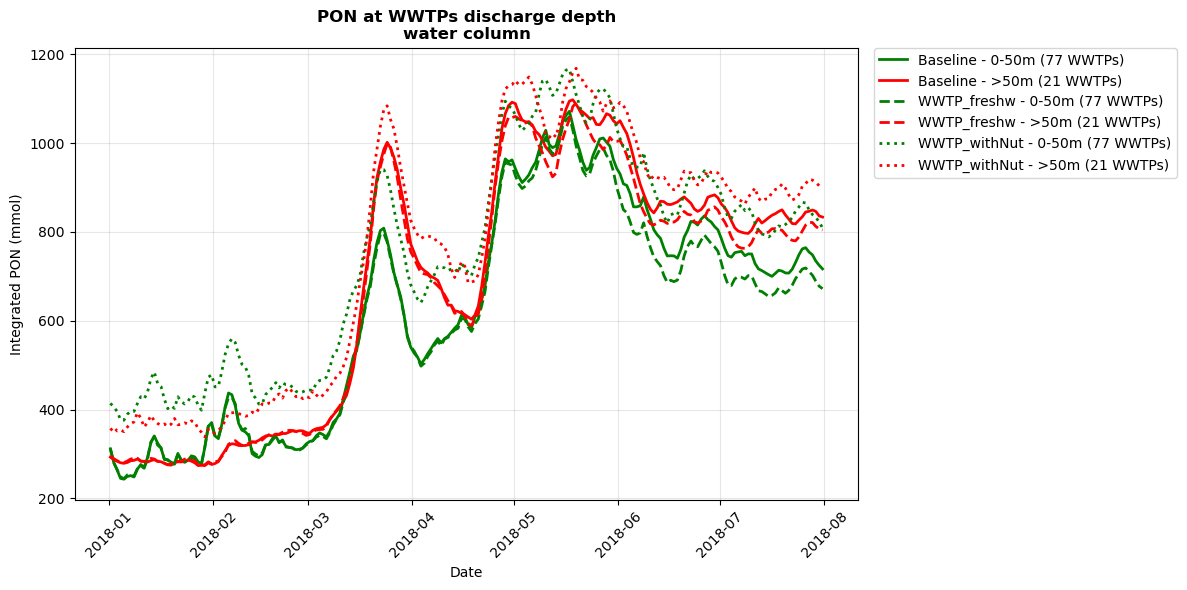

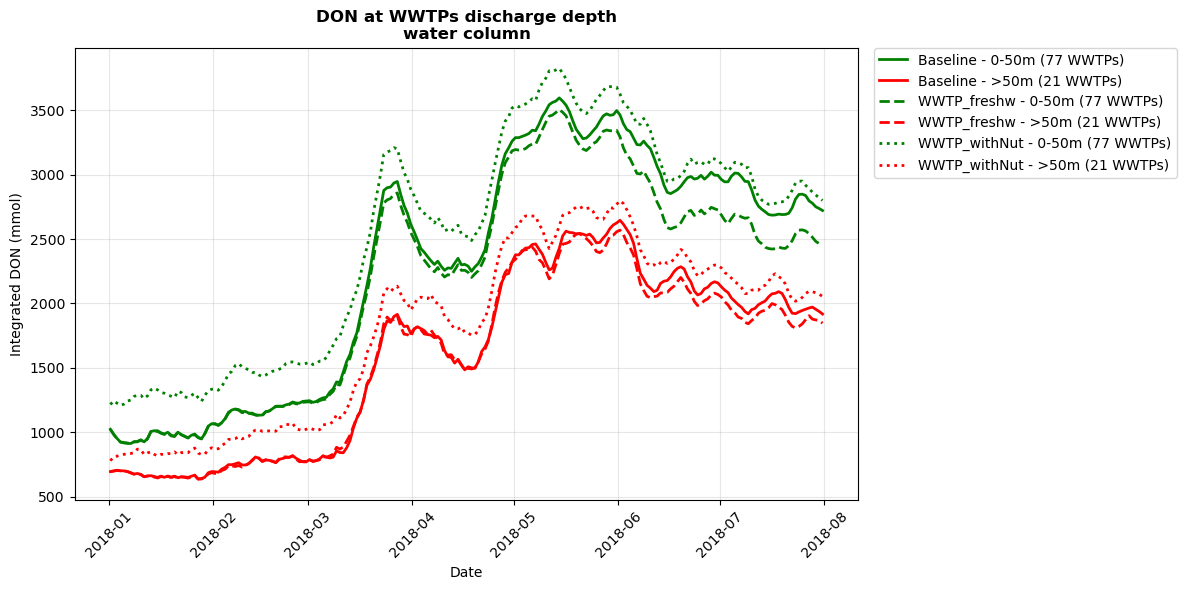

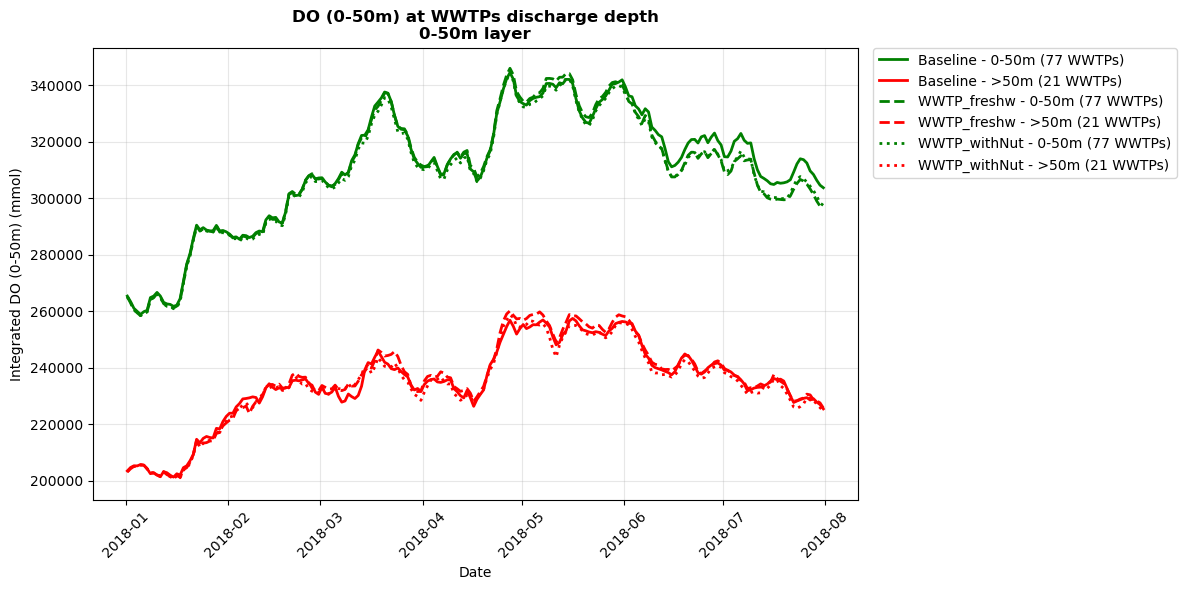

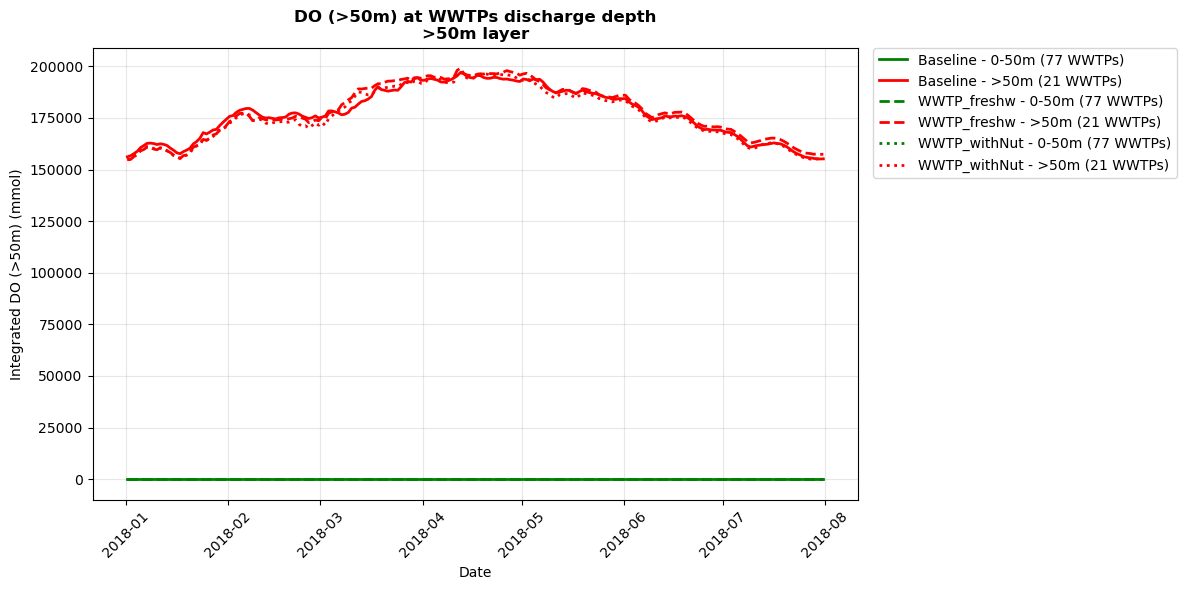

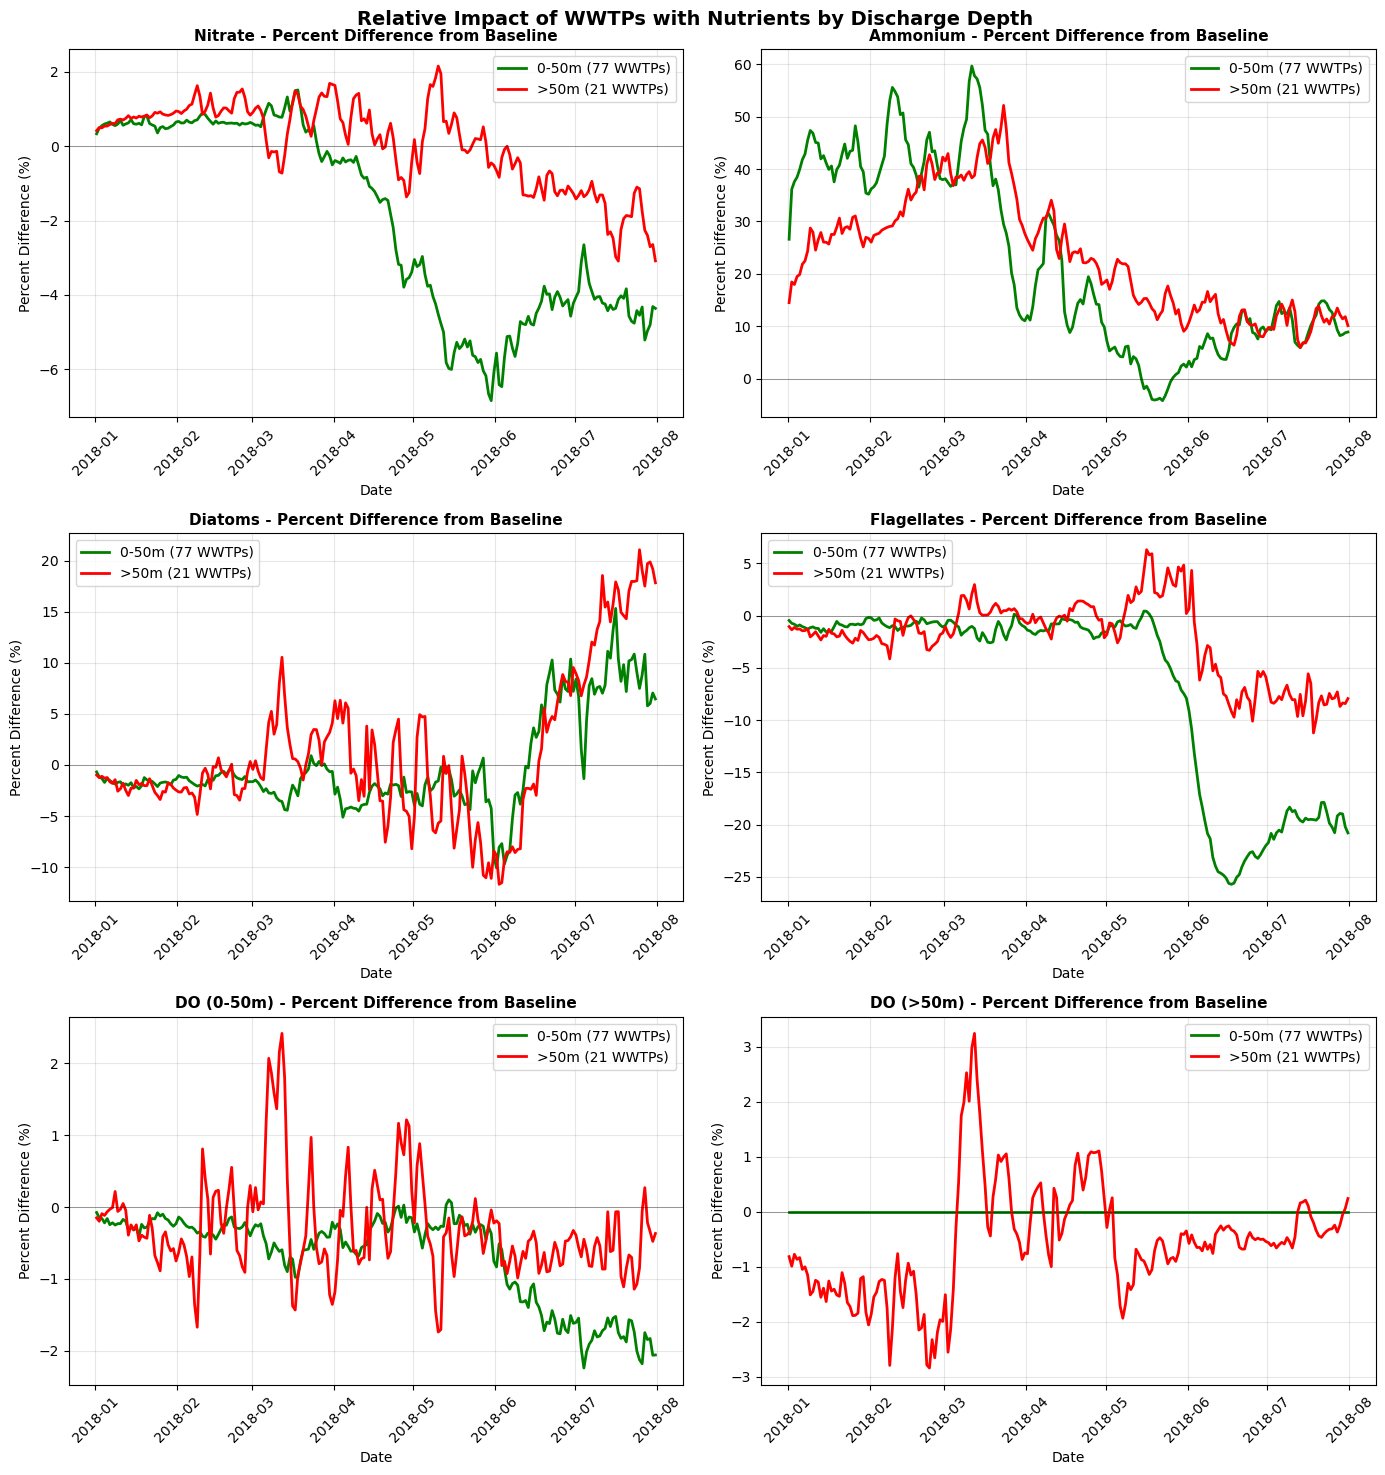

In [17]:
# Main execution
if __name__ == "__main__":
    # Define time period
    start_date = datetime(2018, 1, 1)
    end_date = datetime(2018, 7, 31)  
    
    # Plot WWTP distribution
    plot_wwtp_discharge_depth_distribution()
    
    # Process each simulation
    all_results = {}
    for sim_name, base_path in BASE_PATHS.items():
        results = process_simulation_by_discharge_depth(
            sim_name, base_path, start_date, end_date, category_groups
        )
        all_results[sim_name] = results
    
    # Create plots
    plot_by_discharge_depth(all_results, start_date, end_date)
    plot_relative_impacts(all_results)